In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import LabelEncoder
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
df = pd.read_csv("/content/spam.csv", encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label','text']
df['label'] = df['label'].map({'ham':0, 'spam':1})

stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = text.lower()
    text = "".join([ch for ch in text if ch not in string.punctuation])
    words = [w for w in text.split() if w not in stop_words]
    return " ".join(words)

df['clean'] = df['text'].apply(clean_text)

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['clean'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(df['label'].value_counts())


label
0    4825
1     747
Name: count, dtype: int64


In [13]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

y_pred_train = stump.predict(X_train)
y_pred_test = stump.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


Train Accuracy: 0.8837783262284048
Test Accuracy: 0.8923766816143498
Confusion Matrix:
 [[930  36]
 [ 84  65]]


In [14]:
T = 15
n = X_train.shape[0]
W = np.ones(n) / n
alphas = []
errors = []

models = []

for t in range(T):
    clf = DecisionTreeClassifier(max_depth=1)
    clf.fit(X_train, y_train, sample_weight=W)
    pred = clf.predict(X_train)

    misclassified = (pred != y_train)
    err = np.dot(W, misclassified) / np.sum(W)
    alpha = 0.5 * np.log((1 - err) / (err + 1e-10))

    print(f"Iteration {t+1}")
    print("Misclassified sample indices:", np.where(misclassified)[0][:20])
    print("Weights of misclassified samples:", W[misclassified][:10])
    print("Alpha:", alpha, "\n")

    W = W * np.exp(alpha * misclassified)
    W = W / W.sum()

    models.append((clf, alpha))
    alphas.append(alpha)
    errors.append(err)

# Final prediction
def ada_predict(X):
    final = np.zeros(X.shape[0])
    for clf, a in models:
        final += a * clf.predict(X)
    return (final > 0).astype(int)

y_pred_train = ada_predict(X_train)
y_pred_test = ada_predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, y_pred_train))
print("Test Accuracy:", accuracy_score(y_test, y_pred_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))


Iteration 1
Misclassified sample indices: [ 14  42  49  50  59  62  86  93  96 100 103 115 121 140 142 157 162 194
 195 196]
Weights of misclassified samples: [0.00022437 0.00022437 0.00022437 0.00022437 0.00022437 0.00022437
 0.00022437 0.00022437 0.00022437 0.00022437]
Alpha: 1.0143534599254986 

Iteration 2
Misclassified sample indices: [  9  15  22  31  39  49  59  66  76  88  93 114 115 121 123 159 162 166
 174 194]
Weights of misclassified samples: 1847    0.000186
2052    0.000186
4154    0.000186
3911    0.000186
597     0.000186
1572    0.000514
5537    0.000514
1713    0.000186
5526    0.000186
716     0.000186
Name: label, dtype: float64
Alpha: 0.7967295309244513 

Iteration 3
Misclassified sample indices: [ 15  31  39  49  50  59  66  76  86  88  93  96 100 114 115 123 157 159
 162 166]
Weights of misclassified samples: 2052    0.000343
3911    0.000343
597     0.000343
1572    0.000945
2401    0.000426
5537    0.000945
1713    0.000343
5526    0.000343
4758    0.000426
716

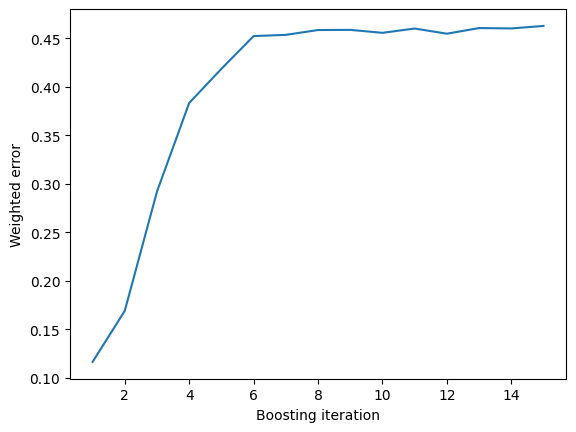

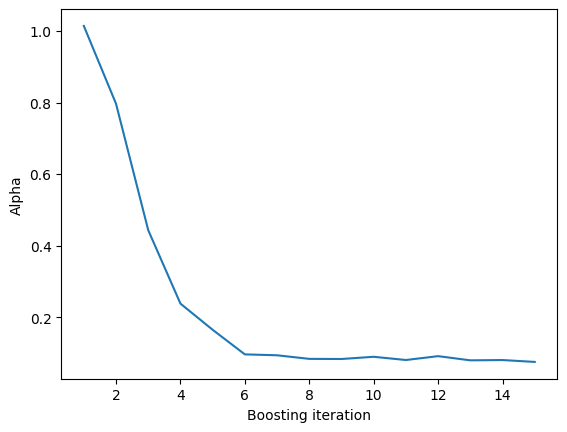

In [15]:
plt.plot(range(1,T+1), errors)
plt.xlabel("Boosting iteration")
plt.ylabel("Weighted error")
plt.show()

plt.plot(range(1,T+1), alphas)
plt.xlabel("Boosting iteration")
plt.ylabel("Alpha")
plt.show()


In [17]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)
ada.fit(X_train, y_train)

print("Train Accuracy:", ada.score(X_train, y_train))
print("Test Accuracy:", ada.score(X_test, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, ada.predict(X_test)))

Train Accuracy: 0.9169845187345749
Test Accuracy: 0.9246636771300448
Confusion Matrix:
 [[966   0]
 [ 84  65]]


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Load UCI Heart Dataset
df = pd.read_csv("/content/heart.csv")

# Features & Label
X = df.drop("target", axis=1)
y = df["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Decision Stump (Weak Learner)
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)

# Predictions
y_pred_train = stump.predict(X_train)
y_pred_test = stump.predict(X_test)

# Results
print("Train Accuracy:", stump.score(X_train, y_train))
print("Test Accuracy:", stump.score(X_test, y_test))
print("\nConfusion Matrix (Test):\n")
print(confusion_matrix(y_test, y_pred_test))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test))


Train Accuracy: 0.7695121951219512
Test Accuracy: 0.7219512195121951

Confusion Matrix (Test):

[[71 29]
 [28 77]]

Classification Report:

              precision    recall  f1-score   support

           0       0.72      0.71      0.71       100
           1       0.73      0.73      0.73       105

    accuracy                           0.72       205
   macro avg       0.72      0.72      0.72       205
weighted avg       0.72      0.72      0.72       205



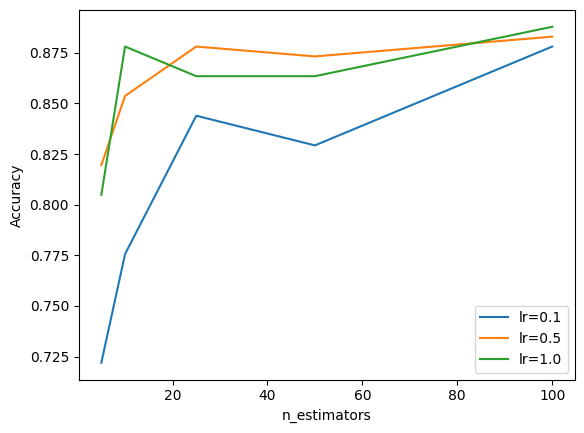

Best: (0.8878048780487805, 1.0, 100)


In [22]:
n_estimators = [5, 10, 25, 50, 100]
lr = [0.1, 0.5, 1.0]
results = {}

for l in lr:
    acc = []
    for n in n_estimators:
        ada = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=l
        )
        ada.fit(X_train, y_train)
        acc.append(ada.score(X_test, y_test))
    results[l] = acc
    plt.plot(n_estimators, acc, label=f"lr={l}")

plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

best = max([(results[l][i], l, n_estimators[i]) for l in lr for i in range(len(n_estimators))])
print("Best:", best)

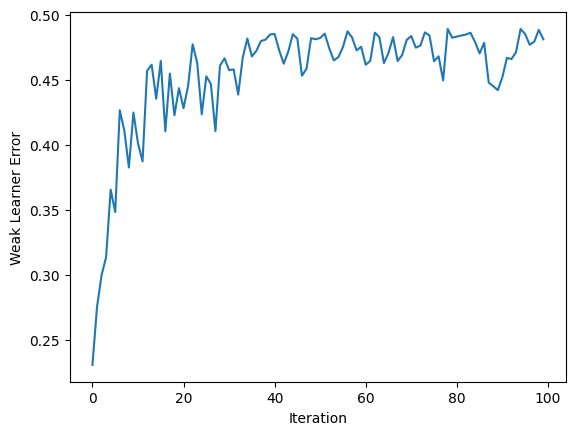

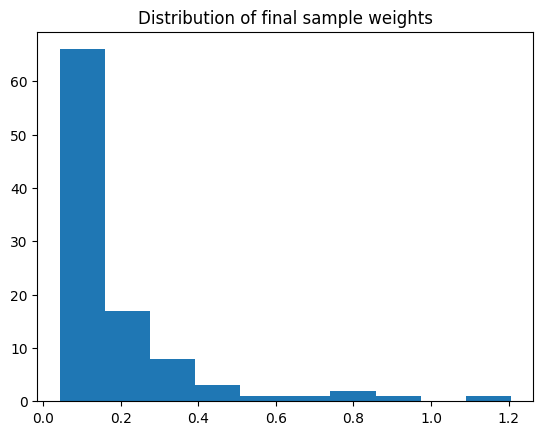

In [23]:
best_lr = best[1]
best_n = best[2]
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr
)
ada.fit(X_train, y_train)

plt.plot(ada.estimator_errors_)
plt.xlabel("Iteration")
plt.ylabel("Weak Learner Error")
plt.show()

plt.hist(ada.estimator_weights_)
plt.title("Distribution of final sample weights")
plt.show()

Top 5 Features:
chol → 0.18231385241039436
oldpeak → 0.17798910695368575
thalach → 0.15880541576036022
age → 0.09668624383868425
trestbps → 0.09546498128423847


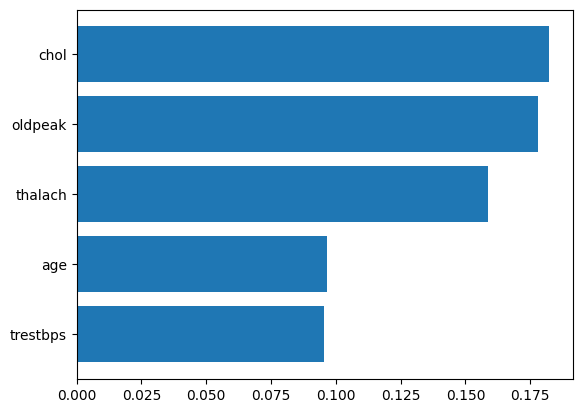

In [24]:
importances = ada.feature_importances_
sorted_idx = np.argsort(importances)[::-1]

print("Top 5 Features:")
for i in range(5):
    print(X.columns[sorted_idx[i]], "→", importances[sorted_idx[i]])

plt.barh(X.columns[sorted_idx[:5]], importances[sorted_idx[:5]])
plt.gca().invert_yaxis()
plt.show()


In [25]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("piyanit/wisdm-ar-v11")

print("Path to dataset files:", path)

100%|██████████| 10.7M/10.7M [00:00<00:00, 195MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/piyanit/wisdm-ar-v11/versions/1


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = "/root/.cache/kagglehub/datasets/piyanit/wisdm-ar-v11/versions/1/WISDM_ar_v1.1_raw.txt"

df = pd.read_csv(file_path, header=None, on_bad_lines="skip")
# The file is already split into columns by pd.read_csv, no need for .str.split on df[0]
df.columns = ["user","activity","timestamp","x","y","z"]

df = df.dropna()

# Remove trailing semicolon and convert to numeric
df["x"] = df["x"].astype(str).str.replace(";", "", regex=False)
df["y"] = df["y"].astype(str).str.replace(";", "", regex=False)
df["z"] = df["z"].astype(str).str.replace(";", "", regex=False)

df["x"] = pd.to_numeric(df["x"], errors="coerce")
df["y"] = pd.to_numeric(df["y"], errors="coerce")
df["z"] = pd.to_numeric(df["z"], errors="coerce")
df = df.dropna()

vigorous = ["Jogging", "Upstairs"]
df["label"] = df["activity"].apply(lambda x: 1 if x in vigorous else 0)

X = df[["x","y","z"]]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Dataset loaded successfully!")
print(f"Samples: {len(df)}")
print(df.head())

Dataset loaded successfully!
Samples: 1086465
   user activity       timestamp         x          y         z  label
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953      1
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424      1
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722      1
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717      1
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164      1


In [35]:
stump = DecisionTreeClassifier(max_depth=1)
stump.fit(X_train, y_train)
print("Train:", stump.score(X_train, y_train))
print("Test:", stump.score(X_test, y_test))
print(confusion_matrix(y_test, stump.predict(X_test)))


Train: 0.6521258341277407
Test: 0.6519021905872247
[[170673  17473]
 [ 95986  41808]]


In [36]:
T = 20
n = X_train.shape[0]
W = np.ones(n) / n
models = []
errors = []
alphas = []

for t in range(T):
    clf = DecisionTreeClassifier(max_depth=1)
    clf.fit(X_train, y_train, sample_weight=W)
    pred = clf.predict(X_train)

    misclassified = (pred != y_train)
    err = np.dot(W, misclassified)
    alpha = 0.5 * np.log((1 - err) / (err + 1e-10))

    print("Round", t+1)
    print("Misclassified idx:", np.where(misclassified)[0][:20])
    print("Misclassified weights:", W[misclassified][:10])
    print("Alpha:", alpha, "\n")

    W = W * np.exp(alpha * misclassified)
    W /= W.sum()

    models.append((clf, alpha))
    errors.append(err)
    alphas.append(alpha)


Round 1
Misclassified idx: [ 0  2  3  5  6  7  8 12 13 16 20 22 27 29 33 39 41 42 46 48]
Misclassified weights: [1.31488117e-06 1.31488117e-06 1.31488117e-06 1.31488117e-06
 1.31488117e-06 1.31488117e-06 1.31488117e-06 1.31488117e-06
 1.31488117e-06 1.31488117e-06]
Alpha: 0.31419835904141846 

Round 2
Misclassified idx: [ 0  1  2  5  6  8 10 12 13 16 17 19 20 22 33 34 37 39 41 42]
Misclassified weights: 250816    0.000002
330949    0.000001
850367    0.000002
567692    0.000002
842835    0.000002
736882    0.000002
937308    0.000001
289684    0.000002
216851    0.000002
388270    0.000002
Name: label, dtype: float64
Alpha: 0.1587779878046216 

Round 3
Misclassified idx: [ 0  1  2  5  6  8 10 12 13 16 17 19 20 22 33 34 39 41 42 43]
Misclassified weights: 250816    0.000002
330949    0.000001
850367    0.000002
567692    0.000002
842835    0.000002
736882    0.000002
937308    0.000001
289684    0.000002
216851    0.000002
388270    0.000002
Name: label, dtype: float64
Alpha: 0.07251449

In [37]:
def ada_predict(X):
    score = np.zeros(X.shape[0])
    for clf, a in models:
        score += a * clf.predict(X)
    return (score > 0).astype(int)

print("Train:", accuracy_score(y_train, ada_predict(X_train)))
print("Test:", accuracy_score(y_test, ada_predict(X_test)))
print(confusion_matrix(y_test, ada_predict(X_test)))


Train: 0.4227605930114066
Test: 0.4227587899613426
[[     0 188146]
 [     0 137794]]


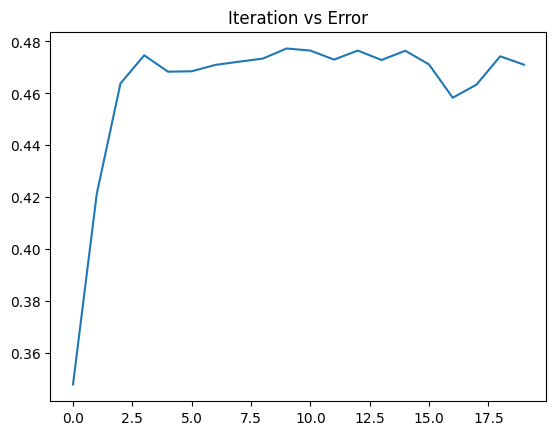

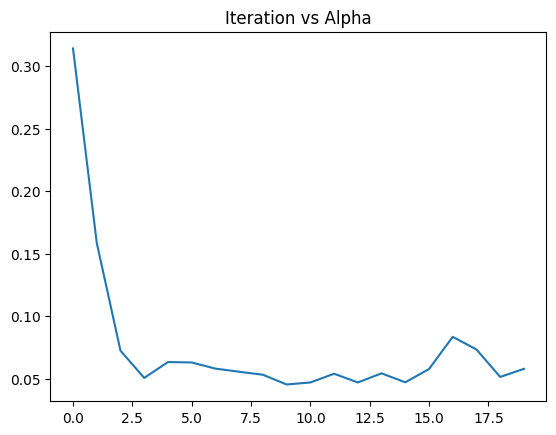

In [38]:
plt.plot(errors); plt.title("Iteration vs Error"); plt.show()
plt.plot(alphas); plt.title("Iteration vs Alpha"); plt.show()


In [40]:
ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0
)
ada.fit(X_train, y_train)
print("Train:", ada.score(X_train, y_train))
print("Test:", ada.score(X_test, y_test))
print(confusion_matrix(y_test, ada.predict(X_test)))

Train: 0.6976115183590283
Test: 0.6969166104190956
[[164210  23936]
 [ 74851  62943]]
